In [1]:
import os
import sys

import matplotlib.pyplot as plt
from hydra import initialize, compose
from glob import glob
import pickle
import numpy as np
from tqdm import tqdm
from PIL import Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses import lens_util
from mejiro.plots import plot
from mejiro.utils import util
from mejiro.helpers import color

In [2]:
side = 4
start = 37
indices = range(start, start + (side ** 2))

In [3]:
def get_sample(pickle_dir, color_dir, index):
    # get lens
    lens_path = os.path.join(pickle_dir, f'lens_{str(index).zfill(8)}')
    lens = util.unpickle(lens_path)

    # get rgb model
    files = glob(pickle_dir + f'/array_{str(index).zfill(8)}_*')
    f106 = [np.load(i) for i in files if 'F106' in i][0]
    f129 = [np.load(i) for i in files if 'F129' in i][0]
    # f158 = [np.load(i) for i in files if 'F158' in i][0]
    f184 = [np.load(i) for i in files if 'F184' in i][0]
    rgb_model = color.get_rgb(f106, f129, f184, minimum=None, stretch=0.2, Q=8)

    # get rgb image
    image_path = os.path.join(color_dir, f'galsim_color_{str(index).zfill(8)}.npy')
    rgb_image = np.load(image_path)

    return lens, rgb_model, rgb_image

In [4]:
color_images, color_model_images, lenses = [], [], []

for index in tqdm(indices):
    lens, rgb_model, rgb_image = get_sample(config.machine.dir_03, config.machine.dir_05, index)
    color_images.append(rgb_image)
    color_model_images.append(rgb_model)
    lenses.append(lens)
    # lens_path = os.path.join(config.machine.dir_05, f'galsim_color_{str(index).zfill(8)}.npy')
    # color_images.append(np.load(lens_path))

100%|██████████| 16/16 [00:00<00:00, 31.24it/s]


In [5]:
subfigure_dir = os.path.join(figure_dir, 'mosaic_pieces')
util.create_directory_if_not_exists(subfigure_dir)
util.clear_directory(subfigure_dir)

for idx, model, image in tqdm(zip(indices, color_model_images, color_images)):
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(model)
    ax[1].imshow(image)
    for a in ax:
        a.axis('off')
        # a.margins(0,0)
        # a.xaxis.set_major_locator(plt.NullLocator())
        # a.yaxis.set_major_locator(plt.NullLocator())
    # ax[0].autoscale_view('tight')
    # ax[1].autoscale_view('tight')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.savefig(os.path.join(subfigure_dir, f'{str(idx).zfill(3)}.png'), pad_inches=0)
    plt.close()

16it [00:04,  3.70it/s]


In [6]:
mosaic_pieces = [np.array(Image.open(f)) for f in glob(subfigure_dir + '/*.png')]

In [7]:
# save_path = os.path.join(figure_dir, 'mosaic_models.png')
# plot.plot_grid(color_model_images, side=side, log10=False, save=save_path)

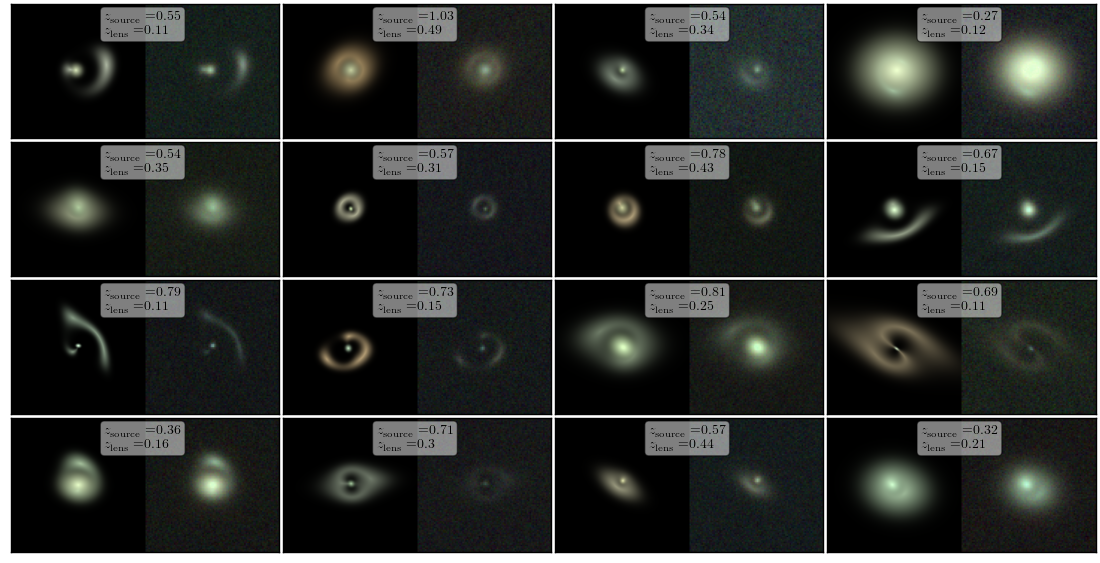

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(14, 14))

grid = ImageGrid(
    fig, 111,
    nrows_ncols=(side, side),
    axes_pad=0.04,
    label_mode='all',
    share_all=True)

# build captions
text_list = []
for lens in lenses:
    caption = r'$z_{\textrm{source}}=$' + str(round(lens.z_source, 2)) + '\n' r'$z_{\textrm{lens}}=$' + str(round(lens.z_lens, 2))
    text_list.append(caption)

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

for i, ax in enumerate(grid):
    im = ax.imshow(mosaic_pieces[i])
    ax.text(0.35, 0.95, text_list[i], transform=ax.transAxes,
                  verticalalignment='top', bbox=props)

grid.axes_llc.set(xticks=[], yticks=[])

save_path = os.path.join(figure_dir, 'mosaic.png')
plt.savefig(save_path)
plt.show()

In [9]:
# from PIL import Image

# list_im = [os.path.join(figure_dir, 'mosaic_models.png'), os.path.join(figure_dir, 'mosaic_galsim.png')]
# imgs    = [ Image.open(i) for i in list_im ]
# # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
# min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
# imgs_comb = np.hstack([i.resize(min_shape) for i in imgs])

# # save
# imgs_comb = Image.fromarray( imgs_comb)
# imgs_comb.save(os.path.join(figure_dir, 'mosaic.png'))    

In [10]:
# fig = plt.figure(figsize=(6, 6))
# outer_grid = fig.add_gridspec(2, 2, wspace=0.04, hspace=0.04)

# grid = 4

# import random
# np.random.seed(42)
# random_indices = random.sample(range(len(color_images)), grid ** 2)

# model_subset = [color_model_images[i] for i in random_indices]
# pandeia_subset = [color_images[i] for i in random_indices]

# subsets = [model_subset, pandeia_subset]

# for i, subset in enumerate(subsets):
#     inner_grid = outer_grid[0, i].subgridspec(4, 4, wspace=0.04, hspace=0.04)
#     ax = inner_grid.subplots()
#     for j, image in enumerate(subset):
#         ax[j // grid, j % grid].imshow(image)
#         ax[j // grid, j % grid].get_xaxis().set_visible(False)
#         ax[j // grid, j % grid].get_yaxis().set_visible(False)

# plt.savefig(os.path.join(figure_dir, 'mosaic.png'))
# plt.show()